# Data Preparation

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd

# Load the dataset
dataset = pd.read_csv('data/gamis1.csv')


In [3]:
# Define sentiment thresholds
positive_threshold = 4
negative_threshold = 2

# Create a new column for sentiment labels
dataset['sentimen'] = ''


In [4]:
# Iterate through the dataset and assign sentiment labels
for index, row in dataset.iterrows():
    rating = row['rating']
    
    if rating >= positive_threshold:
        dataset.at[index, 'sentimen'] = 'positif'
    elif rating <= negative_threshold:
        dataset.at[index, 'sentimen'] = 'negatif'
    else:
        dataset.at[index, 'sentimen'] = 'netral'

In [5]:
# Save the updated dataset
dataset.to_csv('labeled_ds.csv', index=False)

In [6]:
dataset.head()

,review,rating,sentimen
0,makasih sudah sampai paketan nya ...mas kurir ...,5,positif
1,"Barang nya cpt nympe nya,bgs.\nmksh lazada.",5,positif
2,bahannya bagus. baju nya pas di pakai 👍,5,positif
3,alhmdllh brng udh nympe...alhmdllh jg bju ssua...,5,positif
4,bajunya cantik walaupun warnanya aga' beda den...,5,positif


# Text Preprocessing

In [7]:
!pip install sastrawi
import re
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
def normalize_review(review):
    # Clean the text
    review = re.sub('[^a-zA-Z]', ' ', str(review))
    review = review.lower()  # Convert to lowercase

    # Tokenization
    tokens = word_tokenize(review)

    # Initialize Sastrawi stemmer and stopword remover
    stemmer = StemmerFactory().create_stemmer()
    stopwords = StopWordRemoverFactory().get_stop_words()

    # Normalize each token
    normalized_tokens = []
    for token in tokens:
        # Remove stopwords
        if token not in stopwords:
            # Stemming
            stemmed_token = stemmer.stem(token)
            normalized_tokens.append(stemmed_token)

    # Join the tokens back into a single string
    normalized_review = ' '.join(normalized_tokens)
    
    return normalized_review

In [10]:
dataset['review'] = dataset['review'].apply(normalize_review)

In [11]:
dataset.head()

,review,rating,sentimen
0,makasih paket nya mas kurir nya dah langanan s...,5,positif
1,barang nya cpt nympe nya bgs mksh lazada,5,positif
2,bahan bagus baju nya pas pakai,5,positif
3,alhmdllh brng udh nympe alhmdllh jg bju ssuai ...,5,positif
4,baju cantik walaupun warna aga beda realpict n...,5,positif


In [12]:
# Save the updated dataset
dataset.to_csv('data/preprocessed.csv', index=False)


# Building Model

## Split dataset

In [13]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X = dataset['review']  # Input features (normalized reviews)
y = dataset['sentimen']  # Target variable (sentiment labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from gensim.models import Word2Vec

# Train a Word2Vec model on your corpus (X_train)
embedding_dim = 100  # Adjust the embedding dimension based on your requirements
embedding_model = Word2Vec(sentences=X_train, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Get word embeddings for your vocabulary
word_vectors = embedding_model.wv


In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create a tokenizer to convert words to tokens
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of tokens
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_seq_length = 100  # Adjust the sequence length based on your data
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_seq_length, padding='post')

# Convert sentiment labels to numerical values
sentiment_mapping = {'negatif': 0, 'netral': 1, 'positif': 2}
y_train_numerical = [sentiment_mapping[label] for label in y_train]
y_test_numerical = [sentiment_mapping[label] for label in y_test]


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Build the sentiment analysis model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_seq_length))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/10
3/3 [==============================] - 7s 765ms/step - loss: 1.0813 - accuracy: 0.4538 - val_loss: 1.0034 - val_accuracy: 0.8182
Epoch 2/10
3/3 [==============================] - 1s 197ms/step - loss: 0.9660 - accuracy: 0.9000 - val_loss: 0.8918 - val_accuracy: 0.8182
Epoch 3/10
3/3 [==============================] - 1s 215ms/step - loss: 0.8258 - accuracy: 0.9000 - val_loss: 0.7391 - val_accuracy: 0.8182
Epoch 4/10
3/3 [==============================] - 1s 220ms/step - loss: 0.6187 - accuracy: 0.9000 - val_loss: 0.6089 - val_accuracy: 0.8182
Epoch 5/10
3/3 [==============================] - 1s 212ms/step - loss: 0.4396 - accuracy: 0.9000 - val_loss: 0.6415 - val_accuracy: 0.8182
Epoch 6/10
3/3 [==============================] - 1s 245ms/step - loss: 0.4135 - accuracy: 0.9000 - val_loss: 0.7511 - val_accuracy: 0.8182
Epoch 7/10
3/3 [==============================] - 1s 259ms/step - loss: 0.4469 - accuracy: 0.9000 - val_loss: 0.7931 - val_accuracy: 0.8182
Epoch 8/10
3/3 [====

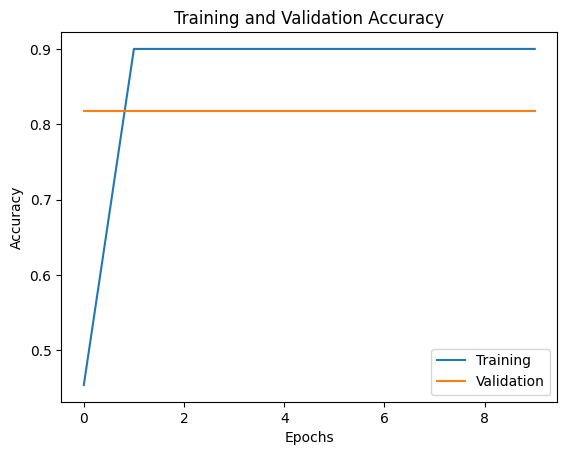

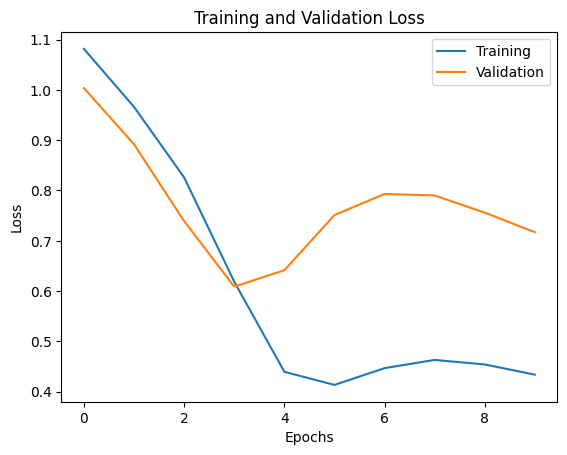

In [26]:
import numpy as np

# Convert the input data to numpy arrays
X_train_padded = np.array(X_train_padded)
X_test_padded = np.array(X_test_padded)
y_train_numerical = np.array(y_train_numerical)
y_test_numerical = np.array(y_test_numerical)

# Train the sentiment analysis model
batch_size = 64
epochs = 10

history = model.fit(X_train_padded, y_train_numerical, batch_size=batch_size, epochs=epochs, validation_data=(X_test_padded, y_test_numerical))

# Access the training history
print(history.history.keys())

# Plot the training and validation accuracy over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()


In [27]:
# Update the sentiment mapping dictionary to include all label indices
sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
# Make predictions on the training data
train_predictions = model.predict(X_train_padded)
train_predicted_labels = [sentiment_mapping[np.argmax(pred)] for pred in train_predictions]

# Convert the true labels to sentiment labels
y_train_labels = [sentiment_mapping[label] for label in y_train_numerical]

# Calculate the accuracy
train_accuracy = sum(np.array(train_predicted_labels) == np.array(y_train_labels)) / len(y_train_labels)
print("Training Accuracy:", train_accuracy)


5/5 [==============================] - 2s 108ms/step
Training Accuracy: 0.9


In [28]:
# Save the model
model.save("sentiment_analysis_model.h5")


# test

In [53]:
import re
import json
import requests

url = 'https://shopee.co.id/Premium-Brill-Eighty-eight-Flannel-Shirt-077-i.32031549.1991571675'

r = re.search(r'i\.(\d+)\.(\d+)', url)
shop_id, item_id = r[1], r[2]
ratings_url = 'https://shopee.co.id/api/v2/item/get_ratings?filter=0&flag=1&itemid={item_id}&limit=20&offset={offset}&shopid={shop_id}&type=0'
reviews=['bahannya jelek']
offset = 0
max_revs=100
while True:

    data = requests.get(ratings_url.format(shop_id=shop_id, item_id=item_id, offset=offset)).json()

    # uncomment this to print all data:
    #print(json.dumps(data, indent=4))

    i = 1
    for i, rating in enumerate(data['data']['ratings'], 1):
        #print(rating['author_username'])
        print(rating['comment'])
        print(rating['rating'])
        #reviews.append(rating['comment'])
        print('-' * 80)

    if i % 20:
        break

    offset += 20

Gak bisa berkata apa2 dah, saking bagusnya. Kainnya bagus, tebal. Nyaman dipake, cocok utk formal dn non formal juga. Utk warna merahnya bagus, rekomendasi bet dah. Thx seller...
1
--------------------------------------------------------------------------------
Mantapppppp bagus bgt 
Nyesel cuman beli satu😌
Bahan tebel 
Ok
Ukuran dan warna sesuai pesanan 
Rekomend banget deh toko nya 😍🥰
1
--------------------------------------------------------------------------------
Barang bagus, alhamdulillah pas buat anak smp kls1. Kecepatan pengiriman baek, respon penjual baek.pokoknya jangan ragu order ditoko know. Good job 👍👍👍👍👍
1
--------------------------------------------------------------------------------
Kualitas produk sangat bagus, pengiriman barang aman, bahan nya juga tebal, tapi kalo menurut saya ukuran untuk XL panjang badan sama tangan nya kurang panjang agak beberapa Cm, minimal tambah sedikit panjang tangan sama badannya.
1
---------------------------------------------------------

In [49]:
print(reviews)

['bahannya jelek', 'Gak bisa berkata apa2 dah, saking bagusnya. Kainnya bagus, tebal. Nyaman dipake, cocok utk formal dn non formal juga. Utk warna merahnya bagus, rekomendasi bet dah. Thx seller...', 'Mantapppppp bagus bgt \nNyesel cuman beli satu😌\nBahan tebel \nOk\nUkuran dan warna sesuai pesanan \nRekomend banget deh toko nya 😍🥰', 'Barang bagus, alhamdulillah pas buat anak smp kls1. Kecepatan pengiriman baek, respon penjual baek.pokoknya jangan ragu order ditoko know. Good job 👍👍👍👍👍', 'Kualitas produk sangat bagus, pengiriman barang aman, bahan nya juga tebal, tapi kalo menurut saya ukuran untuk XL panjang badan sama tangan nya kurang panjang agak beberapa Cm, minimal tambah sedikit panjang tangan sama badannya.', 'Mohon maaf atas bintang satu nya kak. Secara keseluruhan pelayanan emang baik dri penjual udah di return juga tetapi tidak bisa mengganti produk yg dibeli di awal walopun barang habis. Semoga kedepannya jangan sampai terulang. Lancar terus rejekinya kak. Semoga Allah men

In [51]:
def preprocess_text(text):
    # Clean the text by removing unwanted characters
    text = re.sub(r'[^\w\s]', '', text)
    # Perform additional text preprocessing steps specific to Indonesian language if needed
    # ...
    return text

In [52]:
# Preprocess the Indonesian texts
preprocessed_texts = [preprocess_text(text) for text in reviews]

# Convert preprocessed texts to sequences and pad them
new_sequences = tokenizer.texts_to_sequences(preprocessed_texts)
new_padded = pad_sequences(new_sequences, maxlen=max_seq_length, padding='post')

# Make predictions on the preprocessed Indonesian texts
predictions = model.predict(new_padded)
predicted_labels = [sentiment_mapping[np.argmax(pred)] for pred in predictions]

# Print the predictions
for text, label in zip(reviews, predicted_labels):
    print(f'Text: {text} \nPrediksi Sentimen : {label}\n')

TypeError: expected string or bytes-like object, got 'NoneType'